## Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [5]:
import numpy as np
import torch as pt
import torch.autograd as agrad
import matplotlib.pyplot as plt
from util.plot_tools import *
from architecture.fno_1d import *
from boundary_solvers.blobs import *
from boundary_solvers.geometry import *
from scipy.sparse.linalg import LinearOperator #, gmres
from operators.stokes_operator import StokesAdjointBoundaryOp
from boundary_solvers.geometry_torch import unpack_data, unpack, subsample, integrate, subdict, concat_dict_entries, to_dtype, mean_distance, projection
from boundary_solvers.geometry_torch import arclength, normalize, curvature, invariant_quantities, project_to_natural, to_device, GeomData, spectral_rescale
from torch.nn.utils import clip_grad_norm_
from util.logger import EventTracker
from util.dashboard import DashBoard 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import time

print("WARNING: sigmoid normalisation used for architectures older than 45")
print("WARNING: Error in dist_norm for architectures older than 48")


def get_net(settings, device, dtype):
    bias = settings["bias"] if "bias" in settings else True
    activation = settings["activation"] if "activation" in settings else F.gelu
    kernel_size = settings["kernel_size"] if "kernel_size" in settings else 1
    batch_norm = settings["batch_norm"] if "batch_norm" in settings else False
    
    net = FNO1d(modes=settings["modes"], 
                in_channels=len(settings["input_features"]), 
                out_channels=len(settings["output_features"]), 
                layer_widths=settings["layer_widths"],
                bias = bias,
                activation=activation,
                kernel_size=kernel_size,
                batch_norm=batch_norm,
                dtype=dtype)
    
    net.to(device)
    if settings["skip"]:
        class SkipNet(nn.Module):
            def __init__(self, net):
                super(SkipNet, self).__init__()
                self.net = net
            
            def forward(self, x):
                return self.net(x) + x[:, -4:, :]
        net = SkipNet(net)
    return net

### Setup

Load and transform the data, Split into training and test. Create network

In [6]:
# Meta
save_name = "fnoskip_big_data"
dtype = "float"
cdtype = torch.cfloat
device = "cuda:0"
data_dir = "/home/emastr/deep-micro-slip-model/data/micro_geometries_boundcurv_repar_256_torch/data_big_clean.torch"
dash_dir = "/home/emastr/deep-micro-slip-model/data/dashboard/"
state_dir = "/mnt/data0/emastr/article_training_nodecay"
# Features
inp_features = ['c_norm', 'vt', 'vn', 'dvt_norm', 'dvn_norm']#GeomData.PREDEFINED_INPUTS['FIX:invariant-natural']
out_features = GeomData.PREDEFINED_OUTPUTS['FIX:invariant-natural']
key_features = ['vt', 'vn', 'dvt', 'dvn']  # These are the most important features.

# Data
data = GeomData(data_dir, inp_features, out_features, random_roll=True, device=device, dtype=torch.float)
M = len(data)
M_train = int(0.8*M)
M_batch = 32
n_half = 1 # Smallest size to rescale to during training

# Model
settings = {"modes": 40,
            "input_features": inp_features,
            "output_features": out_features,
            "weight_decay": 0,
            "layer_widths": [4*len(inp_features),] * 8, #(3,8) works, (2,8) worse. (8, 3) best so far
            "skip": True,
            "bias": True,
            "activation": F.gelu,
            "kernel_size": 1,
            "batch_norm": True,
            "amsgrad": False}


##### Execute code

train_data, test_data = random_split(data, [M_train, M-M_train])
train_loader = DataLoader(train_data, batch_size=M_batch, shuffle=True)
(X_test, Y_test)  = test_data[:]

net = get_net(settings, device, dtype)

# Predefine list of losses 
N = 40001 #50001 #30001
trainloss = []
testloss  = []

logger = EventTracker()


#save = torch.load(f"{state_dir}/{save_name}_{40000}.Torch")
#net.load_state_dict(save["state dict"])


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Do training

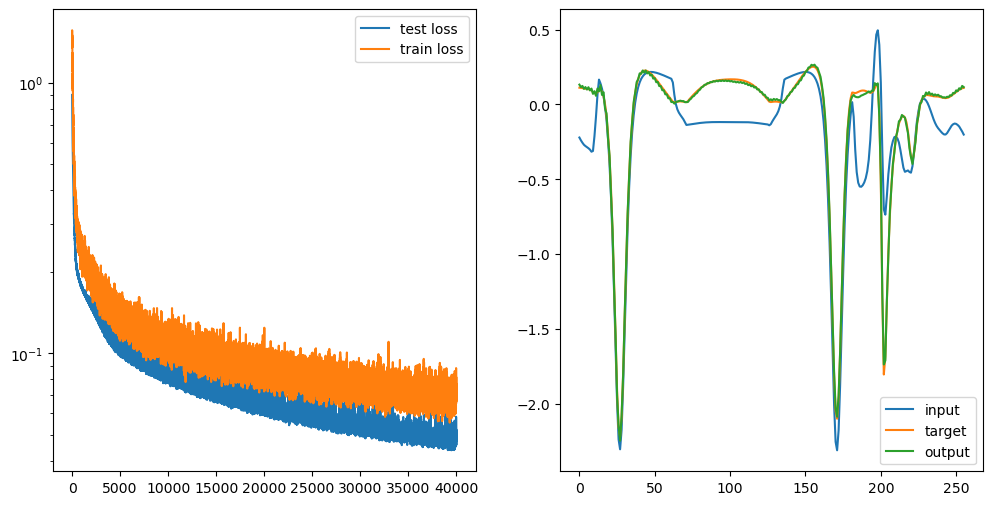

In [ ]:
# Loss function
def mse_normalized(x, y):
    y_norm = torch.linalg.norm(y, dim=-1)[:,:,None] / np.sqrt(y.shape[-1])
    return torch.mean((x - y)**2 / y_norm**2)
    

def deriv(x):
    x_fft = torch.fft.rfft(x, dim=-1)
    freq = 1j * 2 * np.pi * torch.tensor(np.arange(x.shape[-1]//2 + 1))[None, None, :].to(device)
    x_deriv = torch.fft.irfft(x_fft * freq).to(cdtype).real
    return x_deriv


def get_loss(grad_weight=0.0):
    def loss(x, y):
        x_der = deriv(x)
        y_der = deriv(y)
        return mse_normalized(x, y) + grad_weight * mse_normalized(x_der, y_der)
    return loss

loss_fcn = get_loss(grad_weight=1.0)        
loss_save = get_loss(grad_weight=0.0)
optim     = torch.optim.Adam(net.parameters(), weight_decay=settings["weight_decay"], amsgrad=settings["amsgrad"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=1000, T_mult=1, eta_min=0.0001)

# DO TRAINING LOOP 
##################################################
decimate = [1., 0.5, 0.25, 0.5, 1.]
n_dec = len(decimate)

dash = DashBoard(path=dash_dir)
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
ax2 = plt.subplot(122)

dash.add_figure(fig)

for i in range(N):
    logger.start_event("train")
    optim.zero_grad()
    
    (X_batch, Y_batch) = next(iter(train_loader))
    
    #factor = 0.5 * i/N + 0.5
    #factor = min(1., 5/3 * abs(i/N - 0.5) + 1/3)
    factor = 1.
    #factor = 2/3 * (i/N - 0.5)**2 + 1/3
    #factor = decimate[min(n_dec-1,  int(np.floor(i * n_dec / N)))]
    #factor =  0.5 ** float(n_half - np.ceil(n_half * i / N)) 
    #X_batch = spectral_rescale(X_batch, factor)
    #Y_batch = spectral_rescale(Y_batch, factor)
    Y_net = net(X_batch)
    # Train on truncated net that expands as iterations progress
    loss = loss_fcn(Y_net, Y_batch)
    loss.backward()
    optim.step()

    # Test 
    trainloss.append(loss.item() ** 0.5)
    
    Y_test_net = net(X_test)
    testloss.append(loss_save(Y_test_net, Y_test).item() ** 0.5)

    if i % 200 == 0:
        ## update plot
        ax.clear()
        ax2.clear()
        
        ax.plot(testloss, label="test loss")
        ax.plot(trainloss, label="train loss")
        ax.set_yscale("log")
        ax.legend()
        
        
        ax2.plot(X_test[0, -1, :].cpu().detach().numpy(), label="input")
        ax2.plot(Y_test[0, -1, :].cpu().detach().numpy(), label="target")
        ax2.plot(Y_test_net[0, -1, :].cpu().detach().numpy(), label="output")
        ax2.legend()
        
        dash.update_all()
    
    if i % 1000 == 0:
        torch.save({"state dict" : net.state_dict(), 
                    "settings"   : settings,
                    "trainloss"  : trainloss,
                    "testloss"   : testloss}, 
                    f"{state_dir}/{save_name}_{i}.Torch") 
    
    logger.end_event("train")
        
    if i % 50 == 0:
        iter_speed = int(1/logger["train"].time_mean)
        print(f"Step {i}. Train loss = {trainloss[-1]:.2e}, test loss = {testloss[-1]:.2e}, {iter_speed} iter/s, shape={X_batch.shape[-1]}", end="\r")

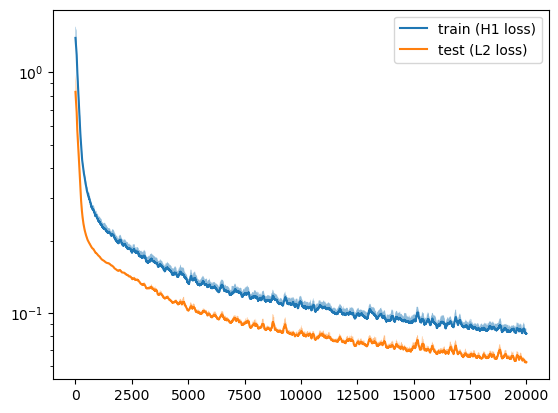

In [ ]:

# names = [f"fnoskip_big_data_{it}" for it in [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49]]


# plt.figure(figsize=(10, 5))
# for name in names:
#     save = torch.load(f"/home/emastr/phd/data/runs/{name}_{20000}.Torch")
#     settings = save["settings"]
#     npar = sum([np.prod(p.shape) for p in save['state dict'].values()])
#     print(f"{name}, {settings}, {npar}")
#     trainloss = save["trainloss"]
#     testloss = save["testloss"]
#     settings = save["settings"]
#     window = 10
#     quantiles = np.array([0.8]) # 80% percentile upper bound
#     iters = np.arange(0,len(save["trainloss"]))
# #    plot_quantiles(plt.gca(), iters, save["trainloss"], quantiles, window, label=f'{name} train (H1 loss)')

#     w = settings['layer_widths'][0] // len(settings['input_features'])
#     h = len(settings['layer_widths'])
#     plot_quantiles(plt.gca(), iters, save["testloss"], quantiles, window, label=f'{name[-2:]}, {w}x{h}, {npar:.2e} test (L2 loss)')

# plt.yscale("log")
# plt.xscale("log")
# plt.legend()
    
save_name = "fnoskip_big_data_50"
save = torch.load(f"{state_dir}/{save_name}_{20000}.Torch")
net = get_net(save["settings"], device, dtype)
net.load_state_dict(save["state dict"])


plt.figure()
trainloss = save["trainloss"]
testloss = save["testloss"]
settings = save["settings"]
window = 100
quantiles = np.array([0.8]) # 80% percentile upper bound
iters = np.arange(0,len(save["trainloss"]))
plot_quantiles(plt.gca(), iters, save["trainloss"], quantiles, window, label='train (H1 loss)')
plot_quantiles(plt.gca(), iters, save["testloss"], quantiles, window, label='test (L2 loss)')
plt.yscale("log")
#plt.xscale("log")
plt.legend()

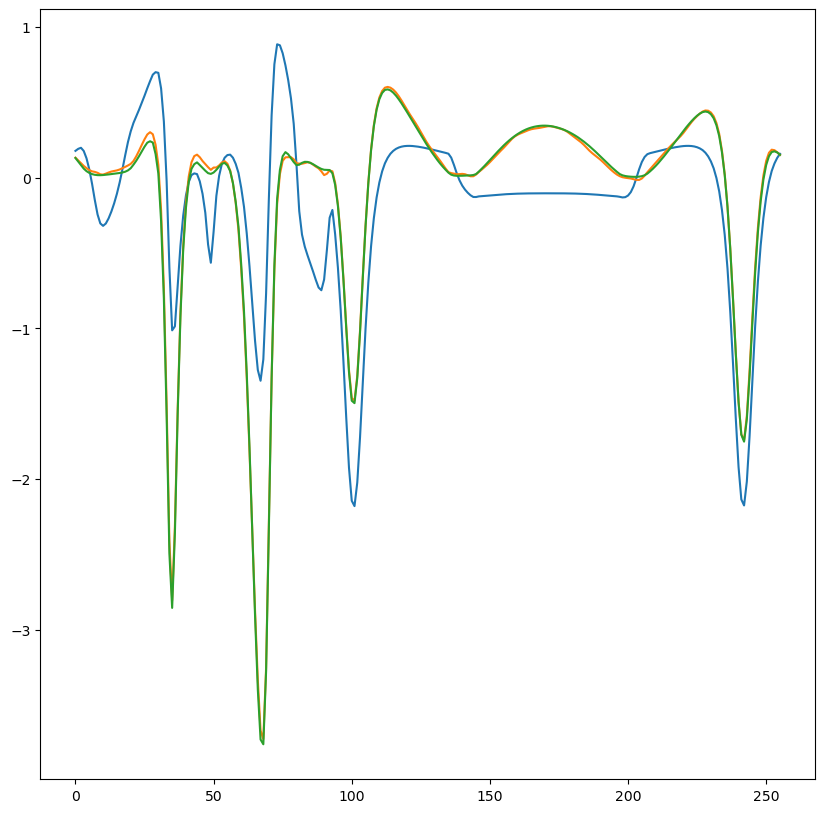

In [ ]:
_2np = lambda x: x.detach().cpu().numpy()

i = 10
plt.figure(figsize=(10,10))
plt.plot(_2np(X_batch[i, -1, :]))
plt.plot(_2np(net(X_batch)[i, -1, :]))
plt.plot(_2np(Y_batch[i, -1, :]))


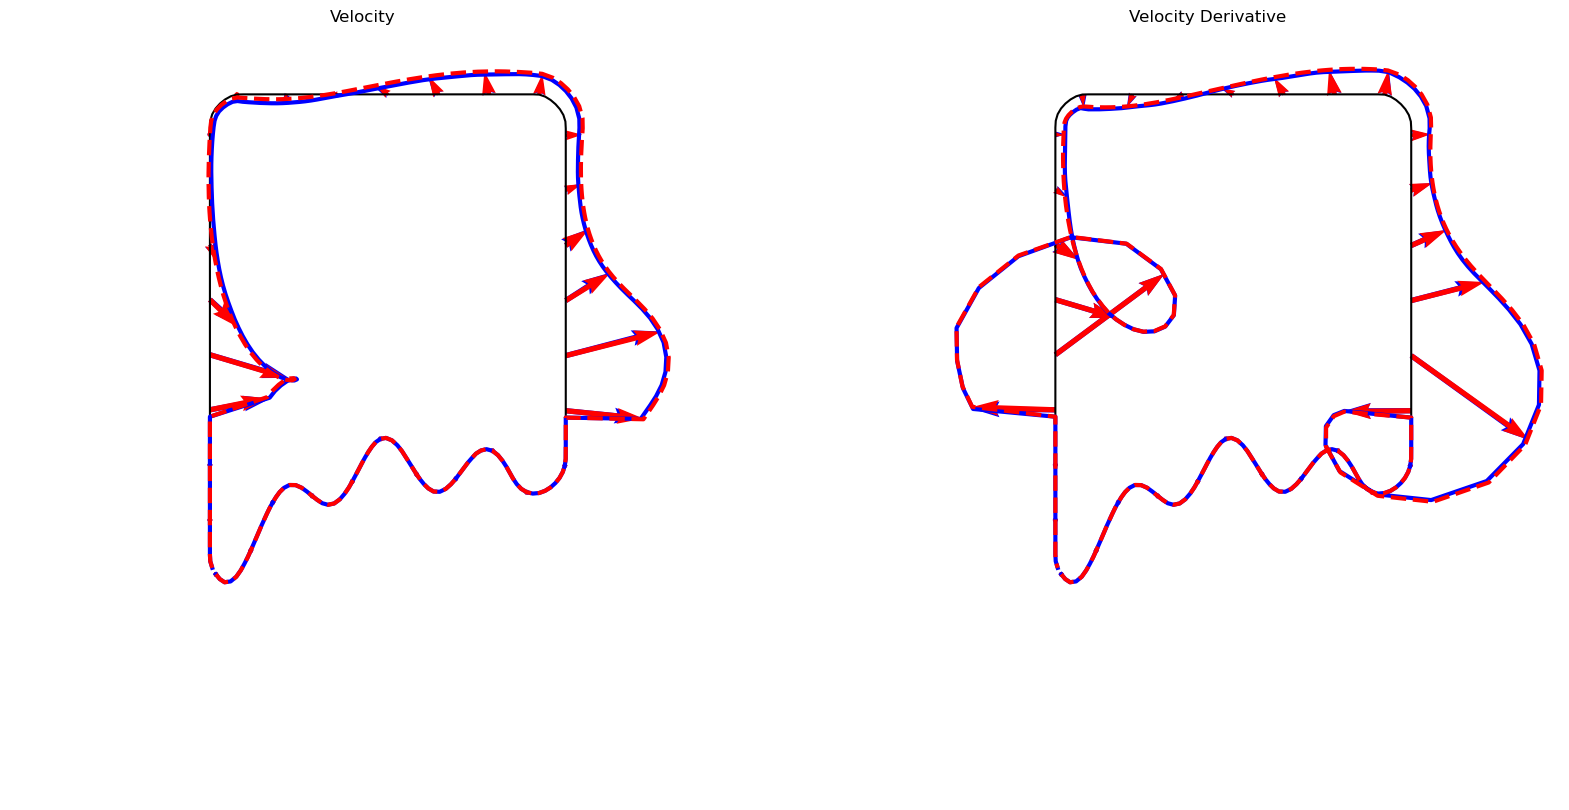

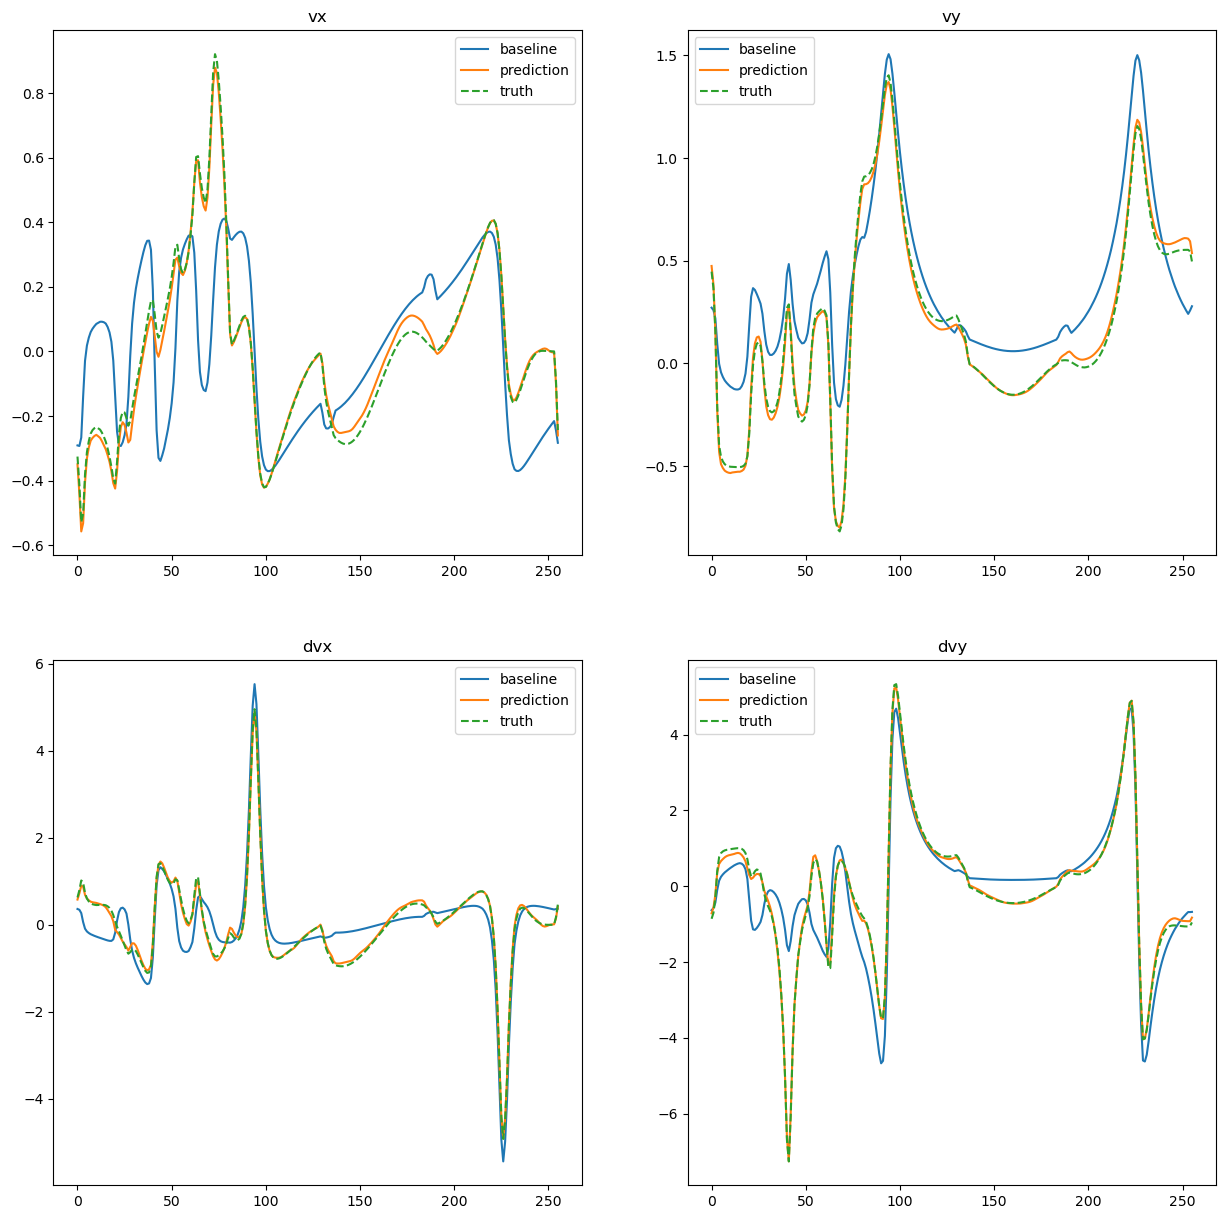

In [ ]:
from boundary_solvers.geometry_torch import norm

idx = 14
test_data.dataset.random_roll = False
X_test, _ = test_data[idx:idx+1]
net.eval()
Y_net = net(X_test).squeeze().detach().cpu().numpy()
X_np_nat = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['tx', 'ty', 'vt', 'vn', 'dvt', 'dvn'])[0].squeeze().detach().cpu().numpy()
X_np = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['vx', 'vy', 'dvx', 'dvy'])[0].squeeze().detach().cpu().numpy()
Y_np = data.concat_to_tensor(test_data.indices[idx:idx+1], out_features=['rx', 'ry', 'drx', 'dry'])[1].squeeze().detach().cpu().numpy()
pts = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['x', 'y'])[0].squeeze().detach().cpu().numpy()

dv_norm = (np.linalg.norm(X_np_nat[-1])**2 + np.linalg.norm(X_np_nat[-2])**2)**0.5 / X_np_nat.shape[-1]**0.5

ux, uy = projection(Y_net[0], Y_net[1], X_np_nat[0], X_np_nat[1], inv=True)
Y_net[0], Y_net[1] = ux, uy


ux, uy = projection(Y_net[2]*dv_norm, Y_net[3]*dv_norm, X_np_nat[0], X_np_nat[1], inv=True)
Y_net[2], Y_net[3] = ux, uy

title = ["Velocity", "Velocity Derivative"]
plt.figure(figsize=(20,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.axis('off')
    plt.title(title[i])
    plt.plot(pts[0,:], pts[1,:], 'k')
    #plt.quiver(pts[0,:], pts[1,:], X_np[-4], X_np[-3], color='red',scale=s)
    
    s, scale, L = 8, (2*i+1)*4, 1.2
    mask = (pts[1] >= 0).astype(float)
    plt.quiver(pts[0,::s], pts[1,::s], mask[::s]*Y_net[2*i + 1, ::s]/scale, -mask[::s]*Y_net[2*i + 0, ::s]/scale, color='blue', scale_units='xy', scale=1)
    plt.quiver(pts[0,::s], pts[1,::s], mask[::s]*Y_np[2*i + 1, ::s]/scale, -mask[::s]*Y_np[2*i + 0, ::s]/scale, color='red', scale_units='xy', scale=1)
    
    plt.plot(pts[0]+mask*Y_net[2*i+1]/scale, pts[1]-mask*Y_net[2*i]/scale, linewidth=3, color='blue', label='prediction')
    plt.plot(pts[0]+mask*Y_np[2*i+1]/scale, pts[1]-mask*Y_np[2*i]/scale, '--', linewidth=3, color='red', label='true')
 
    
    plt.xlim([-L, L])
    plt.ylim([-L, L])

plt.figure(figsize=(15,15))
titles = ["vx", "vy", "dvx", "dvy"]
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(titles[i])
    plt.plot(X_np[i, :], label='baseline')
    plt.plot(Y_net[i, :], label='prediction')
    plt.plot(Y_np[i, :], '--', label='truth')
    plt.legend()
    

1.021024456266807


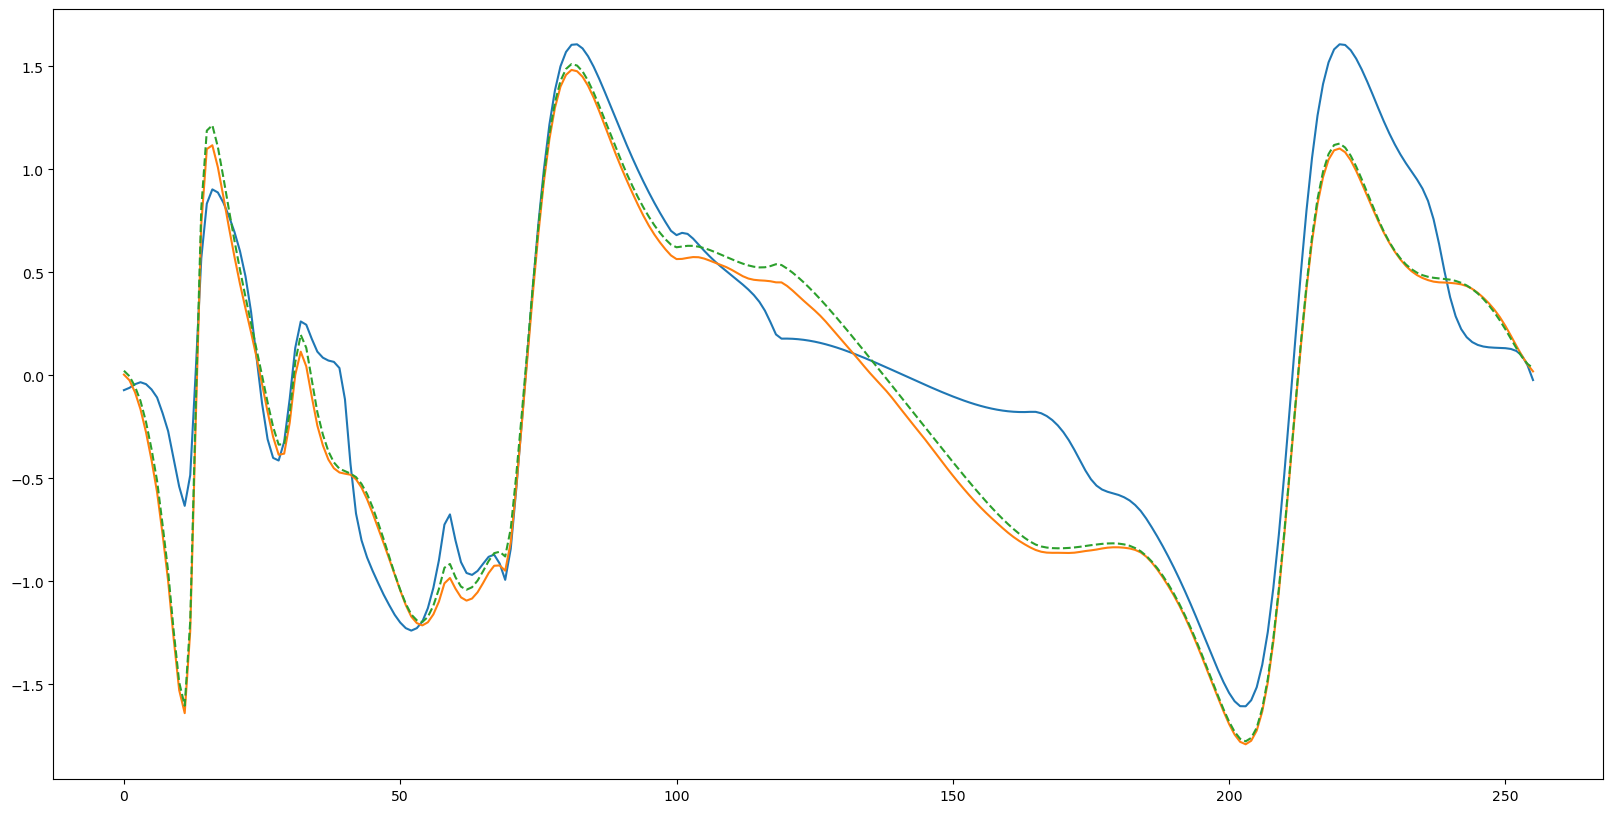

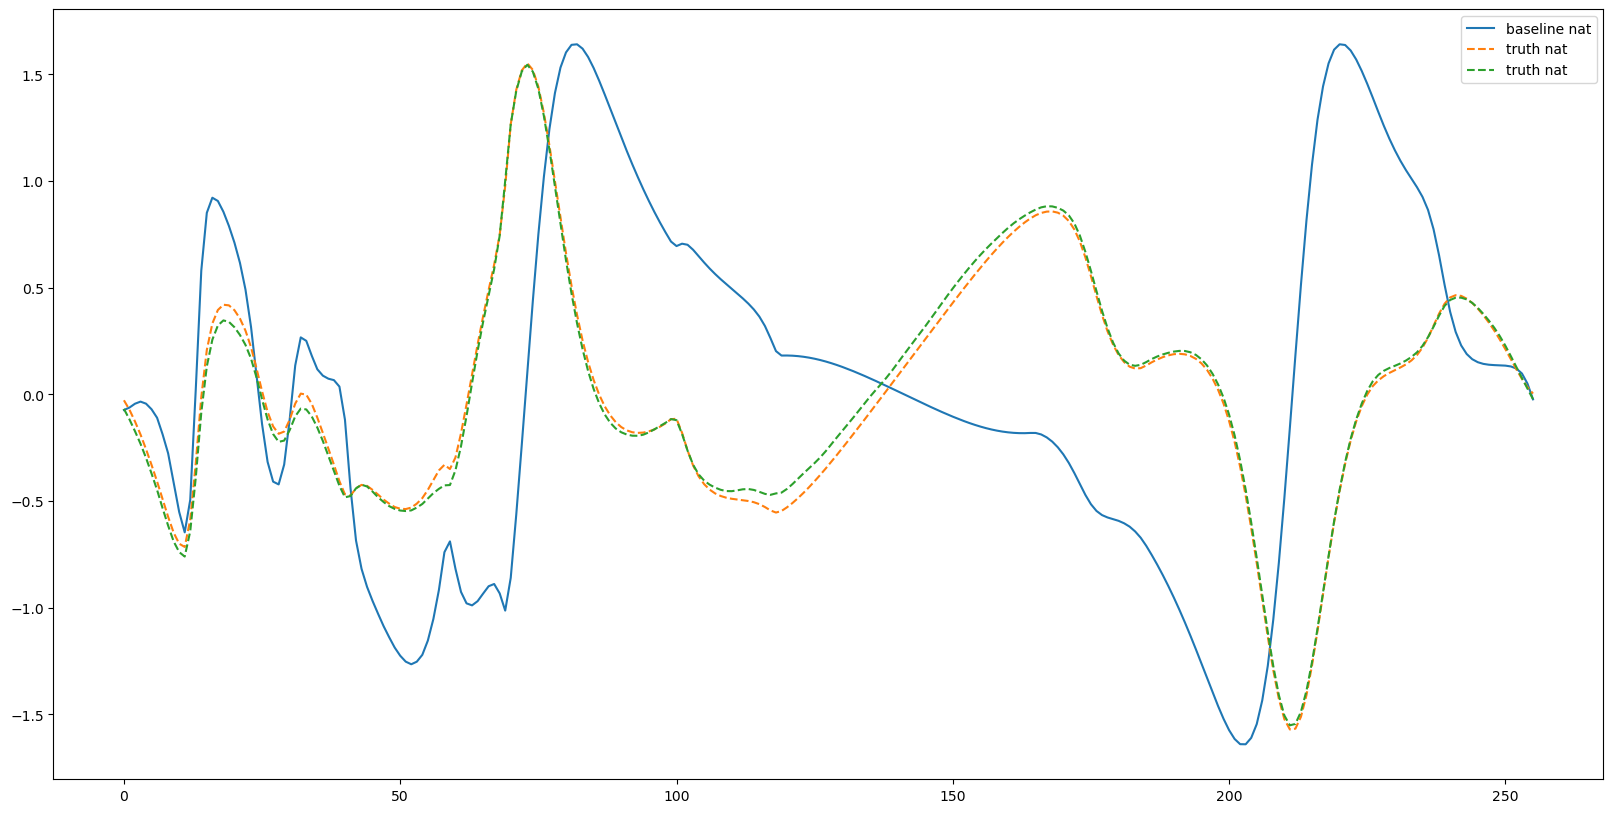

In [ ]:
from boundary_solvers.geometry_torch import norm

idx = 13
test_data.dataset.random_roll = False
X_test, Y_test = test_data[idx:idx+1]
X_np = X_test[0, -2:].cpu().numpy()
Y_np = Y_test[0, -2:].cpu().numpy()
net.eval()
Y_net = net(X_test).squeeze().detach().cpu().numpy()[2:]

X_np_nat = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['tx', 'ty', 'dvt', 'dvn'])[0].squeeze().detach().cpu().numpy()
Y_np_nat = data.concat_to_tensor(test_data.indices[idx:idx+1], out_features=['drt', 'drn', 'drx', 'dry'])[1].squeeze().detach().cpu().numpy()



dv_norm = (np.linalg.norm(X_np_nat[-1])**2 + np.linalg.norm(X_np_nat[-2])**2)**0.5 / X_np_nat.shape[-1]**0.5
ux, uy = projection(Y_net[0]*dv_norm, Y_net[1]*dv_norm, X_np_nat[0], X_np_nat[1], inv=True)


print(dv_norm)

plt.figure(figsize=(20,10))
plt.plot(X_np[0, :], label='baseline')
plt.plot(Y_net[0, :], label='prediction')
plt.plot(Y_np[0, :], '--', label='truth')

plt.figure(figsize=(20,10))
plt.plot(X_np_nat[2, :], label='baseline nat')
plt.plot(Y_np_nat[2, :], '--', label='truth nat')
plt.plot(ux, '--', label='truth nat')
plt.legend()

    

In [ ]:
from boundary_solvers.geometry_torch import norm, sigmoid_normalisation

grid = GaussLegGrid(np.array([0, 2*np.pi]))
nw = 16
grid.WEIGHTS = np.ones((nw,)) / 2 / nw
grid.ABSCISSA = np.linspace(-1, 1, nw+1)[:-1]
grid.refine_all_nply(3)


z = lambda t: np.exp(1j*t) #* (1 + 0.1*np.cos(5*t))
dz = lambda t: 1j*np.exp(1j*t) #* (1 + 0.1*np.cos(5*t)) - 0.5*np.exp(1j*t)*np.sin(5*t)
ddz = lambda t: -np.exp(1j*t) #* (1 + 0.1*np.cos(5*t)) - 0.5j*np.exp(1j*t)*np.sin(5*t) - 2.5*np.exp(1j*t)*np.cos(5*t)

geom = Geometry([z, dz, ddz], grid)

t, _ = grid.get_grid_and_weights()

avg_pre, _ = geom.line_eval_adjoint(-0.4, 0.4, derivative=0, tol=1e-12, maxiter=200, verbose=False)
avg, _ = geom.precompute_line_avg(-0.4, 0.4, derivative=0, tol=1e-12, maxiter=200, verbose=False)

davg_pre, _ = geom.line_eval_adjoint(-0.4, 0.4, derivative=1, tol=1e-12, maxiter=200, verbose=False)
davg, _ = geom.precompute_line_avg(-0.4, 0.4, derivative=1, tol=1e-12, maxiter=200, verbose=False)

c = (dz(t) * np.conjugate(ddz(t))).imag / np.abs(dz(t))**3
#c = 0.8 + 0.2 * np.sin(t)
tan = dz(t) / np.abs(dz(t))
nor = 1j * tan

dist = np.abs(z(t))


vtT  = torch.from_numpy((avg_pre * np.conjugate(tan)).real).float().to(device)
vnT =  torch.from_numpy((avg_pre * np.conjugate(nor)).real).float().to(device)
dvtT  = torch.from_numpy((davg_pre * np.conjugate(tan)).real).float().to(device)
dvnT =  torch.from_numpy((davg_pre * np.conjugate(nor)).real).float().to(device)
cT = torch.from_numpy(c).float().to(device)
cT = sigmoid_normalisation(cT/norm(cT))
distT = torch.from_numpy(dist).float().to(device)


X_in = torch.stack([cT, distT, vtT, vnT, dvtT, dvnT], dim=0).unsqueeze(0)
Y_out = net(X_in).squeeze().detach().cpu().numpy()
avg_pred = (Y_out[0] + 1j*Y_out[1])
avg_pred = (avg_pred.real * tan.real - avg_pred.imag * tan.imag) + 1j * (avg_pred.real * tan.imag + avg_pred.imag * tan.real)

davg_pred = (Y_out[2] + 1j*Y_out[3])
davg_pred = (davg_pred.real * tan.real - davg_pred.imag * tan.imag) + 1j * (davg_pred.real * tan.imag + davg_pred.imag * tan.real)

plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(t, avg_pre.real, label="input, baseline", linewidth=3)
plt.plot(t, avg.real, '--', label="ground truth", linewidth=3)
plt.plot(t, avg_pred.real, '--', label="output, prediction", linewidth=3)
plt.legend()

plt.subplot(2,2,2)
plt.plot(t, avg_pre.imag, label="input, baseline", linewidth=3)
plt.plot(t, avg.imag, '--', label="ground truth", linewidth=3)
plt.plot(t, avg_pred.imag, '--', label="output, prediction", linewidth=3)
plt.legend()

plt.subplot(2,2,3)
plt.plot(t, davg_pre.real, label="input, baseline", linewidth=3)
plt.plot(t, davg.real, '--', label="ground truth", linewidth=3)
plt.plot(t, davg_pred.real, '--', label="output, prediction", linewidth=3)
plt.legend()

plt.subplot(2,2,4)
plt.plot(t, davg_pre.imag, label="input, baseline", linewidth=3)
plt.plot(t, davg.imag, '--', label="ground truth", linewidth=3)
plt.plot(t, davg_pred.imag, '--', label="output, prediction", linewidth=3)
plt.legend()

plt.figure()
geom.plot(plt.gca(), showpts=True)
plt.axis("equal")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x6 and 5x20)

In [ ]:
data_list = []
for idx in range(4):
    data_list.append(torch.load(f"/home/emastr/deep-micro-slip-model/data/micro_geometries_boundcurv_repar_256_torch/data2_{idx}.torch"))

data_new = {'X': torch.concat([data['X'] for data in data_list], dim=0), \
            'Y': torch.concat([data['Y'] for data in data_list], dim=0), \
            'info': data_list[0]['info']}


#data_new = {'X': torch.concat((data1['X'], data2['X']), dim=0), 'Y': torch.concat((data1['Y'], data2['Y']), dim=0), 'info': data1['info']}
#torch.save(data_new, "/home/emastr/deep-micro-slip-model/data/micro_geometries_boundcurv_repar_256_torch/data_new.torch")

# Remove nan values
X = data_new['X']
Y = data_new['Y']
mask = torch.isnan(Y).any(dim=(1,2))
X = X[~mask]
Y = Y[~mask]
torch.save({'X': X, 'Y': Y, 'info': data_new['info']}, "/home/emastr/deep-micro-slip-model/data/micro_geometries_boundcurv_repar_256_torch/data_new.torch")

print(data_new['info'])
